In [90]:
import numpy as np
from utils import make_nice_plots
import matplotlib.pyplot as plt
from default_globals import *
import astropy.units as u
from astropy import constants
from scipy.stats import truncnorm

make_nice_plots()

In [91]:
# TODO: Monte Carlo over uncertainties in single analysis
# TODO: Monte Carlo many full analysis over catalog realizations according to redshift errors

0.1971932369366298


/tmp/ipykernel_35139/3334493096.py:34: RuntimeWarning: invalid value encountered in log10
  lbol = np.log10(Grp2Lbol(m, z).value)


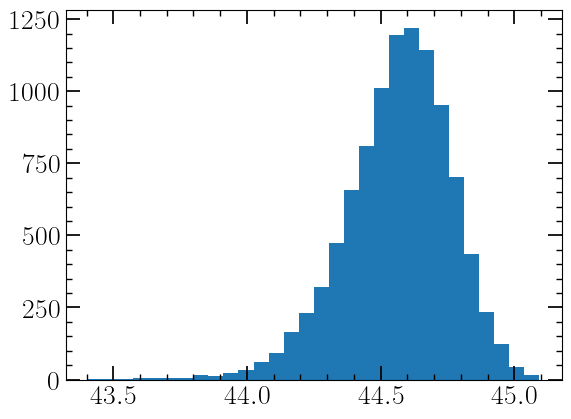

In [264]:
def Grp2fluxdens(Grp):
    """
    Flux density in Jansky from Gaia GRP magnitude
    """
    ZPRP_VEG = 24.7479  # Photometric zero-point in the Vega system for the Gaia GRP band
    C_NU = 3.299e-36  # Jy s / e-
    fluxdens = 10**(-0.4 * (Grp - ZPRP_VEG))  # e- / s
    return fluxdens * C_NU * u.Jy


def Grp2Lbol(Grp, z):
    """
    Bolometric luminosity in erg / s from Gaia GRP magnitude and redshift
    """
    
    N = 10000
    # LAMBDA_GRP = np.random.normal(loc=7750, scale=300, size=N) * u.Angstrom
    # EXPONENT = np.random.normal(loc=-0.657, scale=0.1, size=N)
    BOL_CORR = np.random.normal(loc=11.004, scale=3, size=N)
    relative_zerror = 0.15
    z = truncnorm.rvs(a=(1e-4 - z) / (z * relative_zerror), b=np.inf, loc=z, scale=z * relative_zerror, size=N)

    LAMBDA_GRP = 7750 * u.Angstrom  # 7750 Angstrom, center of Gaia GRP band -- https://www.aanda.org/articles/aa/pdf/2018/09/aa33462-18.pdf state 630 to 1050 nm from https://www.aanda.org/articles/aa/pdf/2018/08/aa32756-18.pdf 
    EXPONENT = -0.657  # Richards+06 -- this one is valid for z<1.5 TODO: get error bar on this       ---> +/- 0.1, maybe 0.05
    # BOL_CORR = 11.004  # Richards+06 -- TODO: get error bar on this                                 ---> +/- 3

    NU_GRP = (constants.c / LAMBDA_GRP).to(u.Hz)
    lumdist = COSMO.luminosity_distance(z)
    nu_Lnu = NU_GRP * Grp2fluxdens(Grp) * 4 * np.pi * lumdist**2 * (1 + z)**EXPONENT * BOL_CORR
    return nu_Lnu.to(u.erg / u.s)

z = 1
m = -50
lbol = np.log10(Grp2Lbol(m, z).value)
lbol = lbol[lbol > 0]

plt.hist(lbol, bins=30)
# plt.xlim(44, 46)
print(np.std(lbol))

# Error in logLbol scales roughly proportional to the relative error in redshift and drives the uncertainty. After that, the error in the Richards+06 bolometric correction is most dominant. The errors in the exponent and the Grp wavelength are subdominant.
